#  Utilizing Llama4 long context window to do data generation by role playing without RAG

You can also check this cookbook in colab [here](https://colab.research.google.com/drive/1a0tRLJGEIkDUds3_3gfRfka7rWEKnPW0?usp=sharing)

<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>



This notebook provides a comprehensive guide on configuring and utilizing CAMEL's data distillation pipeline to generate high-quality mathematical reasoning datasets featuring detailed thought processes (Long Chain-of-Thought data).


In this notebook, you'll explore:

- **CAMEL**: A powerful multi-agent framework that enables synthetic data generation and multi-agent role-playing scenarios, enabling advanced AI-driven applications.
- **Data distillation pipeline**: A systematic approach for extracting and refining high-quality reasoning datasets with detailed thought processes from models like DeepSeek R1.
- **Hugging Face Integration**: A streamlined process for uploading and sharing distilled datasets on the Hugging Face platform.



Through the use of our synthetic data generation pipeline, CAEML-AI has crafted three comprehensive datasets that are now available to enhance your mathematical reasoning and problem-solving skills. These datasets are hosted on Hugging Face for easy access:


Perfect for those eager to explore AI-driven problem-solving or dive deep into mathematical reasoning! 🚀✨

## 📦 Installation

Firstly, we need to install the camel-ai package for datagen pipeline

In [ ]:
%%capture
!pip install "git+https://github.com/camel-ai/camel.git@ac1ba3055d687f6d971c28db80a22882646f1bd7#egg=camel-ai"

## Import the necessary module

In [ ]:

import os
from colorama import Fore, init
import json
from datetime import datetime
import traceback
from camel.messages import BaseMessage
from camel.societies import RolePlaying
from camel.utils import print_text_animated
from camel.agents import ChatAgent
from camel.configs import OpenRouterConfig
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType


## 🔑 Setting Up API Keys

Let's set the `OPENROUTER_API_KEY` that will use Llama4  to do data generation

---



In [ ]:
from getpass import getpass
import os

In [ ]:
OPENROUTER_API_KEY = getpass('Enter your OPENROUTER_API_KEY: ')
os.environ["OPENROUTER_API_KEY"] = OPENROUTER_API_KEY

In [ ]:
!ls

## 📥 utilizing llama4 long context window to directly generate the topics which base on your basic content file

In [ ]:



def load_input_file(file_path):
    """Load input content from a file"""
    with open(file_path, "r", encoding="utf-8") as file:
        content = file.read()
    return content

def save_topics(topics, output_file):
    """Save the list of topics to a file"""
    with open(output_file, "w", encoding="utf-8") as f:
        for topic in topics:
            f.write(f"{topic}\n")
    print(Fore.CYAN + f"Topics saved to: {output_file}")

def generate_topics(model, input_content, num_topics=5):
    """Generate a list of topics from the input content"""
    system_message = f"""You are an AI assistant skilled at extracting topics from text.
Based on the provided text content, generate {num_topics} highly relevant and diverse topics.
Topics should be concise and clear, one per line, without numbering or other markers."""

    chat_agent = ChatAgent(system_message=system_message, model=model)

    message = f"""Please generate {num_topics} highly relevant and diverse topics based on the following content:

{input_content}

Remember, just provide the list of topics, one per line, without numbering or other markers."""

    try:
        response = chat_agent.step(message)
        if not response.msgs or len(response.msgs) == 0:
            print("Warning: The model returned an empty response")

        topics_text = response.msgs[0].content
        topics = [line.strip() for line in topics_text.strip().split('\n') if line.strip()]
        return topics[:num_topics]
    except Exception as e:
        print(f"Error generating topics: {str(e)}")
        return []

# Initialize color output
init()



# add your topic input file
print(Fore.YELLOW + "add your basic content file:")

input_file = "merged.txt"

# Configure parameters
output_file = "generated_topics.txt"
num_topics = 10  # You can modify this directly to adjust the number of generated topics

# Initialize model
model = ModelFactory.create(
    model_platform=ModelPlatformType.OPENROUTER,
    model_type=ModelType.OPENROUTER_LLAMA_4_SCOUT_FREE,
    model_config_dict=OpenRouterConfig(temperature=0.7).as_dict(),
)

# Load content
input_content = load_input_file(input_file)
print(Fore.YELLOW + f"\nInput file loaded: {input_file}")

# Generate topics
print(Fore.MAGENTA + f"\nGenerating {num_topics} topics...")
topics = generate_topics(model, input_content, num_topics)

# Save results
save_topics(topics, output_file)

print(Fore.GREEN + f"Successfully generated {len(topics)} topics!")

##  📤 base on the generated_topic,we utilizing the role playing module from camel and the basic content to generate setting num dialogue data

In [ ]:

def load_topics_from_file(file_path):
    """Load topic list from file"""
    with open(file_path, "r", encoding="utf-8") as file:
        topics = [line.strip() for line in file if line.strip()]
    return topics


def load_context_from_file(file_path):
    """Load context from file"""
    with open(file_path, "r", encoding="utf-8") as file:
        context = file.read().strip()
    return context


def save_dialogue(dialogue, output_dir, topic, index):
    """Save dialogue to JSON file"""
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{topic.replace(' ', '_')}_{index}_{timestamp}.json"
    filepath = os.path.join(output_dir, filename)

    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(dialogue, f, ensure_ascii=False, indent=2)

    print(Fore.CYAN + f"Dialogue saved to: {filepath}")


def generate_dialogue(model, assistant_role, user_role, chat_turn_limit=50, context=None, topic=None):
    """Generate dialogue for a single topic"""
    dialogue = {
        "assistant_role": assistant_role,
        "user_role": user_role,
        "messages": []
    }
    try:

        task_prompt = f"Converse based on the following content:\n\n{context}\n\nDialogue topic: {topic}"

        print(f"[generate_dialogue] Preparing to create RolePlaying instance, task prompt: {task_prompt[:100]}...")
        role_play_session = RolePlaying(
            assistant_role_name=assistant_role,
            assistant_agent_kwargs=dict(model=model),
            user_role_name=user_role,
            user_agent_kwargs=dict(model=model),
            task_prompt=task_prompt,
            with_task_specify=False,
        )
        print("[generate_dialogue] RolePlaying instance created successfully")

        # print(
        #     Fore.GREEN
        #     + f"AI Assistant System Message:\n{role_play_session.assistant_sys_msg}\n"
        # )
        # print(
        #     Fore.BLUE + f"AI User System Message:\n{role_play_session.user_sys_msg}\n"
        # )

        # print(Fore.YELLOW + f"Original Task Prompt:\n{topic}\n")
        # print(
        #     Fore.RED + f"Final Task Prompt:\n{role_play_session.task_prompt}\n"
        # )

        # Reinitialize dialogue messages list
        dialogue["messages"] = []

        # Add initial user message, ensuring the conversation starts with a user message
        initial_user_message = {
            "role": "user",
            "content": f"Instruction: {topic}\nInput: None"
        }
        dialogue["messages"].append(initial_user_message)

        n = 0
        print("[generate_dialogue] Preparing to initialize chat")
        input_msg = role_play_session.init_chat()
        print("[generate_dialogue] Chat initialization completed, starting dialogue loop")

        while n < chat_turn_limit:
            n += 1
            print(f"[generate_dialogue] Dialogue turn {n}/{chat_turn_limit}")
            try:
                print(f"[generate_dialogue] Preparing to call role_play_session.step")
                assistant_response, user_response = role_play_session.step(input_msg)
                print(f"[generate_dialogue] role_play_session.step called successfully")

                # record the assistant response
                if assistant_response.msgs and assistant_response.msgs[0].content:
                    dialogue["messages"].append({
                        "role": "assistant",
                        "content": assistant_response.msgs[0].content
                    })
                else:
                    print(f"[generate_dialogue] Warning: Assistant response is empty or has no content")

                # Record user response (will be used as input in the next loop iteration)
                if user_response.msgs and user_response.msgs[0].content:
                    dialogue["messages"].append({
                        "role": "user",
                        "content": user_response.msgs[0].content
                    })
                else:
                    print(f"[generate_dialogue] Warning: User response is empty or has no content")

                if assistant_response.terminated:
                    reason = assistant_response.info.get('termination_reasons', ['Unknown reason'])
                    print(
                        Fore.GREEN
                        + (
                            "AI Assistant terminated. Reason: "
                            f"{reason}."
                        )
                    )
                    dialogue["messages"].append({"role": "system", "content": f"AI Assistant terminated: {reason}"})
                    break
                if user_response.terminated:
                    reason = user_response.info.get('termination_reasons', ['Unknown reason'])
                    print(
                        Fore.GREEN
                        + (
                            "AI User terminated. "
                            f"Reason: {reason}."
                        )
                    )
                    dialogue["messages"].append({"role": "system", "content": f"AI User terminated: {reason}"})
                    break

                print_text_animated(
                    Fore.BLUE + f"AI User:\n\n{user_response.msgs[0].content}\n"
                )
                print_text_animated(
                    Fore.GREEN + "AI Assistant:\n\n"
                    f"{assistant_response.msgs[0].content}\n"
                )

                if "CAMEL_TASK_DONE" in user_response.msgs[0].content:
                    print("[generate_dialogue] Detected CAMEL_TASK_DONE, ending dialogue")
                    break

                input_msg = assistant_response.msgs[0]
            except Exception as step_e:
                error_trace = traceback.format_exc()
                print(f"[generate_dialogue] Error during dialogue generation (turn {n}): {str(step_e)}\n{error_trace}")
                # Add an error message to the dialogue
                dialogue["messages"].append({
                    "role": "system",
                    "content": f"Error during dialogue generation (turn {n}): {str(step_e)}"
                })
                break

        print("[generate_dialogue] Dialogue generation loop ended")
        return dialogue
    except Exception as e:
        error_trace = traceback.format_exc()
        print(f"[generate_dialogue] Error creating or initializing dialogue: {str(e)}\n{error_trace}")
        # Return a dialogue structure containing error information
        dialogue["messages"].append({
            "role": "system",
            "content": f"Error creating or initializing dialogue: {str(e)}"
        })
        return dialogue


init()

# Interactive parameter setting
print(Fore.CYAN + "\nSet generation parameters (press Enter to use default values)")
topics_file = input("Topics file name (default generated_topics.txt): ") or "generated_topics.txt"
output_dir = input("Output directory name (default generated_dialogues): ") or "generated_dialogues"
num_dialogues = int(input("Number of dialogues to generate per topic (default 1): ") or 1)
assistant_role = input("Assistant role name (default Python Programmer): ") or "Python Programmer"
user_role = input("User role name (default Stock Trader): ") or "Stock Trader"
chat_turn_limit = int(input("Dialogue turn limit (default 6): ") or 6)
context_file = input("Context file name (default basic_context.txt): ") or "basic_context.txt"

# Initialize the model
model = ModelFactory.create(
    model_platform=ModelPlatformType.OPENROUTER,
    model_type=ModelType.OPENROUTER_LLAMA_4_SCOUT_FREE,
    model_config_dict=OpenRouterConfig(temperature=0.7).as_dict(),
)

# Load data
topics = load_topics_from_file(topics_file)
context = load_context_from_file(context_file)
print(Fore.GREEN + f"\nSuccessfully loaded {len(topics)} topics | Context length: {len(context)} characters")

# Generate dialogues
for topic_idx, topic in enumerate(topics, 1):
    print(Fore.MAGENTA + f"\n【Topic {topic_idx}/{len(topics)}】{topic}")
    for dialogue_idx in range(1, num_dialogues+1):
        print(Fore.CYAN + f"Generating dialogue {dialogue_idx}/{num_dialogues}...")
        dialogue = generate_dialogue(
            model=model,
            topic=topic,
            assistant_role=assistant_role,
            user_role=user_role,
            chat_turn_limit=chat_turn_limit,
            context=context
        )
        save_dialogue(dialogue, output_dir, topic, dialogue_idx)

print(Fore.GREEN + "\nAll dialogues generated successfully!")


#Upload the generated data to huggingface

In [5]:
# Import necessary modules and classes
from camel.datahubs.huggingface import HuggingFaceDatasetManager  # Manages interactions with Hugging Face datasets
from camel.datahubs.models import Record  # Represents a single record in the dataset
from datetime import datetime  # Handles date and time operations
import json  # For reading JSON files
import os  # For file path operations
from getpass import getpass

def load_dialogue_file(file_path):
    r"""Load and parse the dialogue JSON file.

    Args:
        file_path (str): Path to the dialogue JSON file.

    Returns:
        dict: The dialogue data from the JSON file.
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data


# Main function: Upload dataset to Hugging Face
def upload_to_huggingface(data, username, dataset_name=None):
    r"""Uploads data to the Hugging Face dataset platform.

    Args:
        data (list or dict): Data to upload, either traces or dialogue data.
        username (str): Hugging Face username.
        dataset_name (str, optional): Custom dataset name.


    Returns:
        str: URL of the uploaded dataset.
    """
    # Initialize HuggingFaceDatasetManager to interact with Hugging Face datasets
    manager = HuggingFaceDatasetManager()

    # Generate or validate the dataset name
    dataset_name = generate_or_validate_dataset_name(username, dataset_name)

    # Create the dataset on Hugging Face and get the dataset URL
    dataset_url = create_dataset(manager, dataset_name)

    # Create a dataset card to add metadata
    create_dataset_card(manager, dataset_name, username)

    # Convert the data into a list of Record objects
    records = create_records_from_dialogue(data)

    # Add the Record objects to the dataset
    add_records_to_dataset(manager, dataset_name, records)

    # Return the dataset URL
    return dataset_url

# Generate or validate the dataset name
def generate_or_validate_dataset_name(username, dataset_name):
    r"""Generates a default dataset name or validates and formats a user-provided name.

    Args:
        username (str): Hugging Face username.
        dataset_name (str, optional): User-provided custom dataset name.


    Returns:
        str: Formatted dataset name.
    """
    if dataset_name is None:
        # If no dataset name is provided, generate a default name with the username and current date
        current_date = datetime.now().strftime("%Y%m%d")

        dataset_name = f"dialogue_data_{current_date}"

    # Format the dataset name to include the username
    return f"{username}/{dataset_name}"

# Create a dataset on Hugging Face
def create_dataset(manager, dataset_name):
    r"""Creates a new dataset on Hugging Face and returns the dataset URL.

    Args:
        manager (HuggingFaceDatasetManager): Instance of HuggingFaceDatasetManager.
        dataset_name (str): Name of the dataset.

    Returns:
        str: URL of the created dataset.
    """
    dataset_url = manager.create_dataset(dataset_name)
    return dataset_url

# Create a dataset card with metadata
def create_dataset_card(manager, dataset_name, username):
    r"""Creates a dataset card to add metadata

    Args:
        manager (HuggingFaceDatasetManager): Instance of HuggingFaceDatasetManager.
        dataset_name (str): Name of the dataset.
        username (str): Hugging Face username.

    """

    # dialogues
    description = "A dataset containing dialogues between assistant and user with different roles."
    content = "This dataset contains dialogues generated using the CAMEL framework. Each entry includes:\n\n" \
                "- Assistant and user roles\n" \
                "- A sequence of messages between the assistant and user\n"
    tags = ["dialogue", "conversation", "role-playing", "instruction"]

    manager.create_dataset_card(
        dataset_name=dataset_name,
        description=description,
        license="mit",  # Using lowercase 'mit' as required by HuggingFace
        tags=tags,
        authors=[username],
        language=["en"],
        task_categories=["text-generation"],
        content=content
    )


# Convert dialogue data into Record objects
def create_records_from_dialogue(dialogue_data):
    r"""Converts dialogue data into a list of Record objects.

    Args:
        dialogue_data (dict): Dialogue data from the JSON file.

    Returns:
        list: List of Record objects.
    """
    messages = dialogue_data.get('messages', [])
    assistant_role = dialogue_data.get('assistant_role', 'Assistant')
    user_role = dialogue_data.get('user_role', 'User')

    record = Record(
        source_type="dialogue",
        assistant_role=assistant_role,
        user_role=user_role,
        messages=messages
    )

    return [record]

# Add Record objects to the dataset
def add_records_to_dataset(manager, dataset_name, records):
    r"""Adds a list of Record objects to the dataset.

    Args:
        manager (HuggingFaceDatasetManager): Instance of HuggingFaceDatasetManager.
        dataset_name (str): Name of the dataset.
        records (list): List of Record objects.
    """
    manager.add_records(dataset_name, records)




Enter your HF_TOKEN: ··········


FileNotFoundError: [Errno 2] No such file or directory: 'generated_dialogues/Customizing_Demos_with_CSS_and_JavaScript_1_20250409_213855.json'

### 🔑 Config Access Token of Hugging Face and Upload the Data

You can go to [here](https://huggingface.co/settings/tokens/new?tokenType=write) to get API Key from Hugging Face, also make sure you have opened the write access to repository.

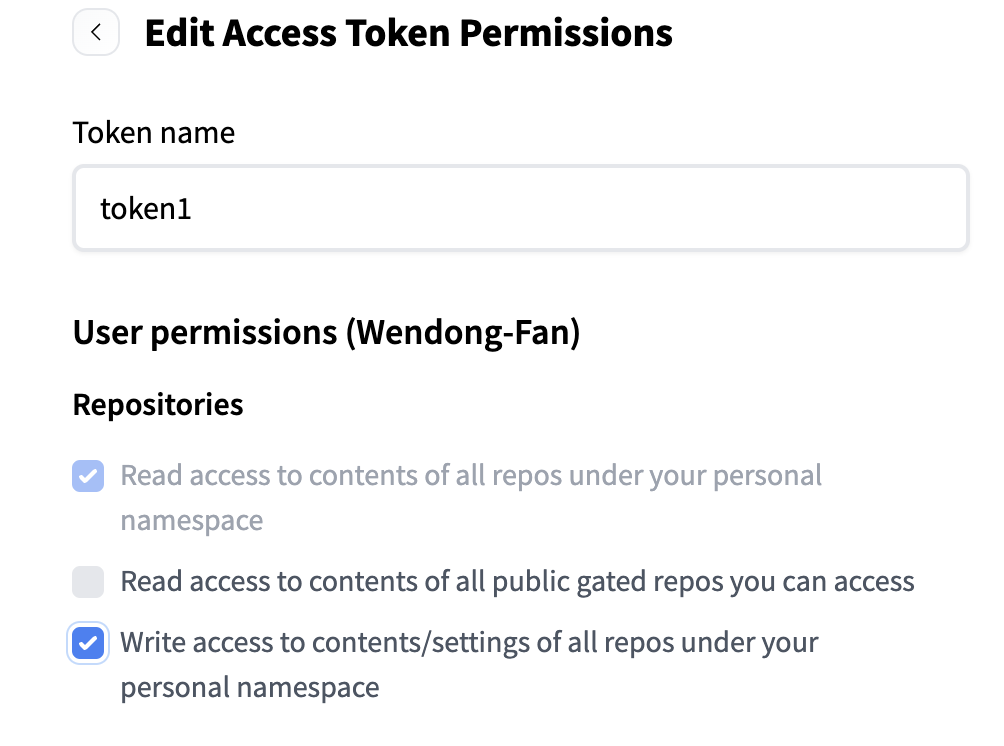

Then create a New Dataset in Hugging Face:

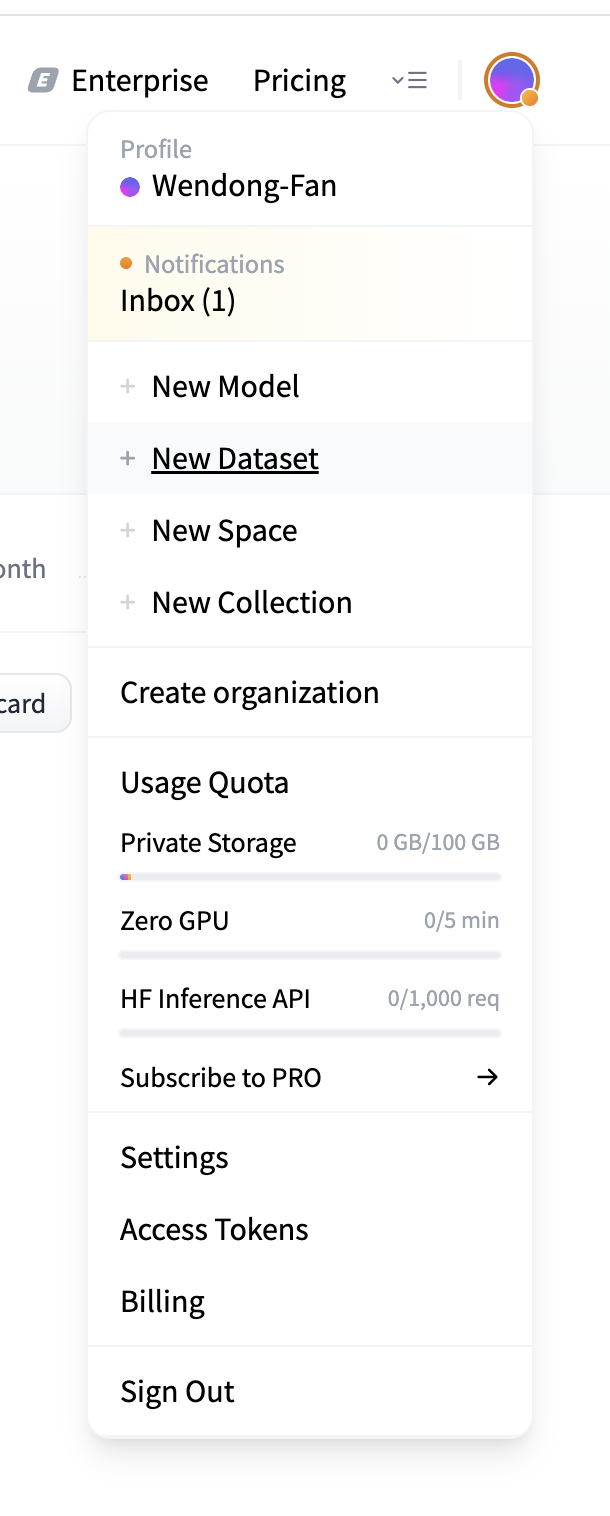

In [6]:
# Get HuggingFace token and username
HUGGING_FACE_TOKEN = getpass('Enter your HUGGING_FACE_TOKEN: ')
os.environ["HUGGING_FACE_TOKEN"] = HUGGING_FACE_TOKEN
username = input("Enter your HuggingFace username: ")
dataset_name = input("Enter your dataset name:")

dialogue = load_dialogue_file("generated_dialogues/Customizing_Demos_with_CSS_and_JavaScript_1_20250409_213855.json")


# Upload the data to HuggingFace
dataset_url = upload_to_huggingface(dialogue, username, dataset_name)
print(f"\nDataset uploaded successfully!")
print(f"You can view your dataset at: {dataset_url}")


Enter your HUGGING_FACE_TOKEN: ··········
Enter your HuggingFace username: zjrwtxtechstudio
Enter your dataset name:test2027


FileNotFoundError: [Errno 2] No such file or directory: 'generated_dialogues/Customizing_Demos_with_CSS_and_JavaScript_1_20250409_213855.json'

## 📊 Final Uploaded Data Preview

## 🌟 Highlights

- **High-Quality Synthetic Data Generation:** CAMEL’s pipeline distills mathematical reasoning datasets with detailed step-by-step solutions, ideal for synthetic data generation.
  
- **Public Datasets:** Includes the **AMC AIME STaR**, **AMC AIME Distilled**, and **GSM8K Distilled Datasets**, providing diverse problems and reasoning solutions across various math topics.

- **Hugging Face Integration:** Easily share and access datasets on Hugging Face for collaborative research and development.

- **Customizable & Scalable:** Supports parallel processing, customizable agents, and reward models for efficient, large-scale data generation.

That's everything: Got questions about 🐫 CAMEL-AI? Join us on [Discord](https://discord.camel-ai.org)! Whether you want to share feedback, explore the latest in multi-agent systems, get support, or connect with others on exciting projects, we’d love to have you in the community! 🤝

Check out some of our other work:

1. 🐫 Creating Your First CAMEL Agent [free Colab](https://docs.camel-ai.org/cookbooks/create_your_first_agent.html)

2.  Graph RAG Cookbook [free Colab](https://colab.research.google.com/drive/1uZKQSuu0qW6ukkuSv9TukLB9bVaS1H0U?usp=sharing)

3. 🧑‍⚖️ Create A Hackathon Judge Committee with Workforce [free Colab](https://colab.research.google.com/drive/18ajYUMfwDx3WyrjHow3EvUMpKQDcrLtr?usp=sharing)

4. 🔥 3 ways to ingest data from websites with Firecrawl & CAMEL [free Colab](https://colab.research.google.com/drive/1lOmM3VmgR1hLwDKdeLGFve_75RFW0R9I?usp=sharing)

5. 🦥 Agentic SFT Data Generation with CAMEL and Mistral Models, Fine-Tuned with Unsloth [free Colab](https://colab.research.google.com/drive/1lYgArBw7ARVPSpdwgKLYnp_NEXiNDOd-?usp=sharingg)

Thanks from everyone at 🐫 CAMEL-AI


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>
